## Introduction

In this project, we will work with a car dataset that contains features such as the car's price, manufacturer, model, mileage, miles per gallon (mpg) etc. and using these features, we will try to build a ML model to predict the car's price.

We will start by loading the data, followed by EDA and data preprocessing before ingesting the data to our ML pipeline.

## Loading + Exploring the data

In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import glob
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
pd.set_option("display.precision", 2)

In [2]:
allFiles = glob.glob("*.csv")
for file in allFiles:
    print(file)

audi.csv
bmw.csv
cclass.csv
focus.csv
ford.csv
hyundi.csv
merc.csv
skoda.csv
toyota.csv
vauxhall.csv
vw.csv


Let's load one of the files and get an idea of the dataset, after which we will combine all the files and create a master database which we will be using for building our Car Price prediction model.

In [3]:
audi = pd.read_csv('audi.csv')
audi.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


So based on this data, we would try to predict the price of the car based on the other features.

Just for our sanity check, let's have a look at one other file as well and see if it's following the same format.

In [4]:
f = pd.read_csv('cclass.csv')
f.head(5)

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0


Now that we have looked at the format of the dataset, let's combine all individual files into one after which we will proceed with carrying out the necessary data preprocessing steps if required.

In [5]:
allFiles = glob.glob("*.csv")
list = []
for file in allFiles:
    df= pd.read_csv(file)
    df["brand"] =  file.split('.')[0].upper() #adding another column which contains the Car Manufacturer/brand as well
    list.append(df)
dataset = pd.concat(list)

In [6]:
dataset.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,tax(£)
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,AUDI,NaN
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,AUDI,NaN
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,AUDI,NaN
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,AUDI,NaN
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,AUDI,NaN


In [7]:
#the tax(£) column can be dropped
cols_to_drop= ['tax(£)'] #if needed, more column names can be added to be dropped
dataset.drop(cols_to_drop, axis = 1, inplace= True)

In [8]:
dataset.shape

(108540, 10)

In [9]:
df = dataset.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108540 entries, 0 to 15156
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           94327 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   brand         108540 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 9.1+ MB


In [10]:
#find how many null values we have per column
df.isnull().sum()/len(df)*100

model            0.00
year             0.00
price            0.00
transmission     0.00
mileage          0.00
fuelType         0.00
tax             13.09
mpg              8.62
engineSize       0.00
brand            0.00
dtype: float64

Given we have 13% and 8.7% of null values in our tax, MPG column, we can either drop these rows or even impute them based on some given criteria.

In [11]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.00,108540.00,108540.00,94327.00,99187.00,108540.00
mean,2017.10,16890.12,23025.93,120.26,55.17,1.66
std,2.13,9756.27,21176.42,63.40,16.14,0.56
min,1970.00,450.00,1.00,0.00,0.30,0.00
25%,2016.00,10229.50,7491.75,125.00,47.10,1.20
50%,2017.00,14698.00,17265.00,145.00,54.30,1.60
75%,2019.00,20940.00,32236.00,145.00,62.80,2.00
max,2060.00,159999.00,323000.00,580.00,470.80,6.60


Using **descriptive statistics** like this, we can find out if there are any specific outliers we might want to address before proceeding. For instance, these are a few data fixes I would like to perform:
 - Here I see the max year is '2060' which is definitely wrong, so I want to dig deeper into it and see if I can replace it or if I have to delete it
 - The minimum mileage and tax is shown as "0", so have to check that as well
 - Looking at the data, it looks like 'tax' and 'engineSize' both have the minimum value as 0, which I believe is not accurate

Instead of dropping these rows, I would like to impute them based on other criterias.


In [12]:
df[df.year==2060]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
17726,Fiesta,2060,6495,Automatic,54807,Petrol,205.0,42.8,1.4,FORD


As there is only 1 row with the year as '2060', we will drop this row.

In [13]:
df = df[df.year!=2060]

In [14]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108539.00,108539.00,108539.00,94326.00,99186.00,108539.00
mean,2017.10,16890.22,23025.64,120.26,55.17,1.66
std,2.13,9756.26,21176.30,63.40,16.14,0.56
min,1970.00,450.00,1.00,0.00,0.30,0.00
25%,2016.00,10230.00,7491.50,125.00,47.10,1.20
50%,2017.00,14698.00,17265.00,145.00,54.30,1.60
75%,2019.00,20940.00,32236.00,145.00,62.80,2.00
max,2020.00,159999.00,323000.00,580.00,470.80,6.60


Also, the year column is inferred as a numeric datatype, so we will change it to a categorical variable before proceeding with our analysis.

In [15]:
df.year= df.year.astype('category')

Next, let's look at the instances where my tax and enginesize is 0 

In [16]:
df[df.tax==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
30,A1,2015,9500,Automatic,54754,Diesel,0.0,76.3,1.6,AUDI
50,A4,2016,12750,Manual,52561,Diesel,0.0,74.3,2.0,AUDI
58,A3,2016,10200,Manual,66369,Diesel,0.0,83.1,1.6,AUDI
60,A1,2013,7000,Manual,76269,Diesel,0.0,74.3,1.6,AUDI
69,A1,2016,10800,Manual,18181,Petrol,0.0,67.3,1.0,AUDI
...,...,...,...,...,...,...,...,...,...,...
14694,Golf SV,2016,10550,Manual,16739,Diesel,0.0,72.4,1.6,VW
14696,Golf SV,2015,8950,Manual,45000,Diesel,0.0,72.4,1.6,VW
14701,Golf SV,2015,9695,Manual,21151,Diesel,0.0,72.4,1.6,VW
14721,Golf SV,2014,8650,Manual,32535,Diesel,0.0,72.4,1.6,VW


In [17]:
df[df.engineSize==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
7505,Q5,2019,44790,Automatic,5886,Petrol,135.0,117.7,0.0,AUDI
7506,Q3,2019,32788,Automatic,1500,Diesel,145.0,47.1,0.0,AUDI
7516,Q3,2020,29944,Manual,1500,Petrol,145.0,40.9,0.0,AUDI
7517,Q3,2020,33333,Automatic,1500,Diesel,145.0,47.1,0.0,AUDI
7518,Q3,2020,29944,Automatic,1500,Petrol,145.0,32.5,0.0,AUDI
...,...,...,...,...,...,...,...,...,...,...
11648,Tiguan,2016,15300,Manual,38398,Diesel,145.0,53.3,0.0,VW
11655,Tiguan,2018,24000,Automatic,22200,Diesel,145.0,47.9,0.0,VW
12821,Up,2017,8500,Manual,20324,Petrol,20.0,64.2,0.0,VW
12879,Up,2017,8000,Manual,24444,Petrol,20.0,60.1,0.0,VW


## Imputing missing values:

#### Impute using the mean, based on certain criteria:

To impute the null values for tax, we can use the mean tax paid for each model/year combination.

In [18]:
df['tax'] = df['tax'].replace(0, np.nan)
df['tax']=df['tax'].fillna(df.groupby(['model','year'])['tax'].transform('mean'))

In [19]:
df[df.tax==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand


As seen, there are no longer null values/zeroes in our tax column.

Next we move on to impute the missing values for the MPG column.
To impute the mpg values, we will consider the mean based on each model,transmission, fuelType pair as I feel all of these 3 will influence the 'mpg' of the vehicle. 

Before imputing, let's quickly plot and see if my hypothesis makes sense.

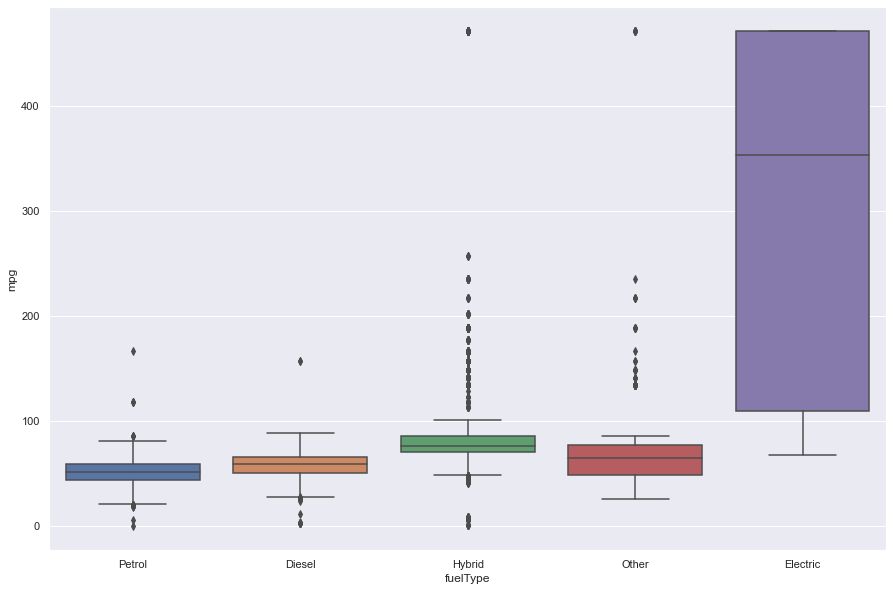

In [20]:
plt.figure(figsize = (15,10))
sns.boxplot(x = 'fuelType', y = 'mpg', data = df);


Interesting to see the MPG distribution for Electric cars, where the 25th percentile is infact higher than the top-most whisker for the other fueltypes.

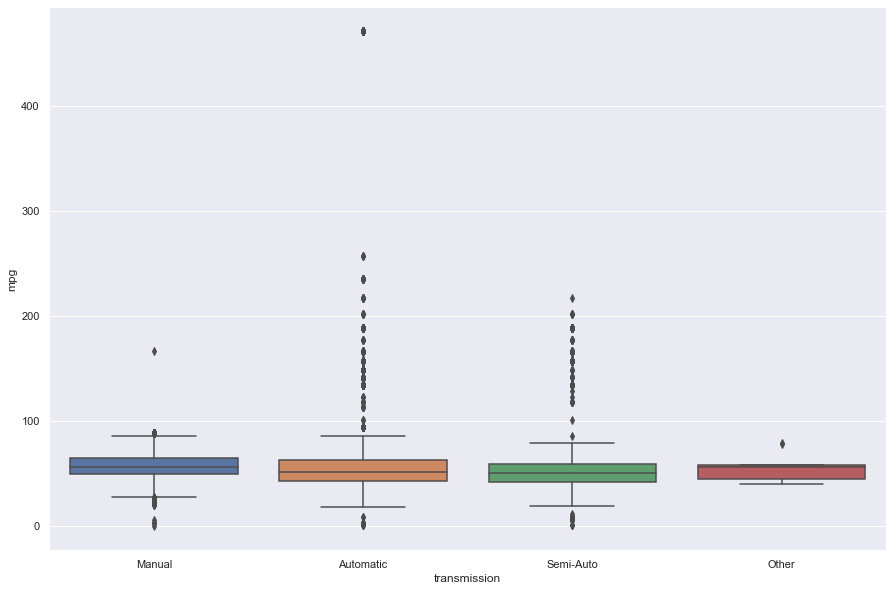

In [21]:
plt.figure(figsize = (15,10))
sns.boxplot(x = 'transmission', y = 'mpg', data = df);

As seen, the 'mpg' distributions is quite different across the different categories for both cases of transmission, fuelType.

Hence we will proceed with the necessary mean imputation as mentioned above.

In [22]:
df.groupby(['model','transmission','fuelType'])['mpg'].mean()

model      transmission  fuelType
 1 Series  Automatic     Diesel       63.96
                         Petrol       44.30
           Manual        Diesel       69.60
                         Petrol       47.41
           Semi-Auto     Diesel       63.02
                                      ...  
 i8        Automatic     Other       134.50
180        Manual        Diesel       72.40
200        Manual        Diesel       64.20
220        Automatic     Diesel       61.40
230        Automatic     Petrol       29.40
Name: mpg, Length: 819, dtype: float64

As seen from the above result, we can calculate the mean for each grouping and use that value to impute our missing values.
But one thing to note is that in the above df, the zeroes are still present, which will bring our average down and we might end up using the wrong mean for our imputation. 

Hence, we can replace the null values with zero and then re-run the above code again. We should expect the average to go up as we are removing the zeroes from the initial calculation.

In [23]:
df['mpg'] = df['mpg'].replace(0, np.nan)
df['mpg']=df['mpg'].fillna(df.groupby(['model','transmission','fuelType'])['mpg'].transform('mean'))

In [24]:
df[df.mpg==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand


In [25]:
df.describe()

,price,mileage,tax,mpg,engineSize
count,108539.00,108539.00,103489.00,108538.00,108539.00
mean,16890.22,23025.64,125.25,55.48,1.66
std,9756.26,21176.30,55.49,15.85,0.56
min,450.00,1.00,10.00,0.30,0.00
25%,10230.00,7491.50,125.00,47.10,1.20
50%,14698.00,17265.00,145.00,55.11,1.60
75%,20940.00,32236.00,145.00,62.80,2.00
max,159999.00,323000.00,580.00,470.80,6.60


Finally, we impute the 0's for the engineSize column as well, as engineSize cannot possibly be zero.

For enginesize, we will use the model/transmission mean value and use it for our imputation.

In [26]:
df.groupby(['model','transmission'])['engineSize'].mean()

model      transmission
 1 Series  Automatic       2.03
           Manual          1.74
           Semi-Auto       2.10
 2 Series  Automatic       1.90
           Manual          1.70
                           ... 
 i8        Automatic       1.50
180        Manual          1.50
200        Manual          2.20
220        Automatic       2.00
230        Automatic       0.00
Name: engineSize, Length: 470, dtype: float64

In [27]:
df['engineSize'] = df['engineSize'].replace(0, np.nan)
df['engineSize']=df['engineSize'].fillna(df.groupby(['model','transmission'])['engineSize'].transform('mean'))

Looks like our data is almost clean and ready to be fed into our ML pipeline. I do want to take a look at the instances where:
    Minimum mileage is 1
    Mimimum mpg is 0.3

In [28]:
redundant_data = (df.mpg < 5) | (df.mileage < 5)

In [29]:
print( redundant_data.sum())
print("*"*30)
print(100*(redundant_data.sum()/len(df)))

102
******************************
0.09397543740038143


So we have a total of 102 rows where either our mileage/mpg is less than 5 and given it's not even 1% of our entire data, we will drop these rows/create another df excluding these values.

In [30]:
#dropping all rows where milegae or mpg is less than 5
df.drop(df[(df.mpg < 5) | (df.mileage < 5)].index, inplace = True) 

In [31]:
df.describe()

,price,mileage,tax,mpg,engineSize
count,107766.00,107766.00,102749.00,107765.00,107764.00
mean,16877.32,23051.49,125.22,55.50,1.67
std,9750.29,21173.59,55.52,15.86,0.55
min,450.00,5.00,10.00,5.50,0.60
25%,10210.00,7500.00,125.00,47.10,1.20
50%,14689.00,17301.50,145.00,55.11,1.60
75%,20895.75,32258.75,145.00,62.80,2.00
max,159999.00,323000.00,580.00,470.80,6.60


Finally checking one more time and dropping all the NaN's before proceeding.

In [37]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102747 entries, 0 to 107765
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         102747 non-null  object 
 1   year          102747 non-null  int64  
 2   price         102747 non-null  int64  
 3   transmission  102747 non-null  object 
 4   mileage       102747 non-null  int64  
 5   fuelType      102747 non-null  object 
 6   tax           102747 non-null  float64
 7   mpg           102747 non-null  float64
 8   engineSize    102747 non-null  float64
 9   brand         102747 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 8.6+ MB


## Building our ML model

Before building, let's first split our data into the necessary training, test and validation set/unseen data.

In [41]:
data = df.sample(frac=0.9, random_state=123) #keeping 90% of the data for training+testing and the remaining 10% as unseen data
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (92472, 10)
Unseen Data For Predictions: (10275, 10)


In [42]:
from pycaret.regression import *
reg01 = setup(data = df, target = 'price', session_id=123, feature_selection = True, use_gpu = True) 

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(102747, 10)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(71922, 223)"


Next, we will compare all the models and chose the best one based on the R2 value and use it for our predictions. 

In [43]:
best = compare_models(exclude = ['ransac','lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1313.7545,4012600.7564,2002.1899,0.9587,0.1281,0.0848,8.8860
rf,Random Forest Regressor,1221.6678,4204066.0292,2049.3907,0.9567,0.1153,0.0784,31.3560
et,Extra Trees Regressor,1219.5386,4324069.5403,2076.1659,0.9555,0.1079,0.0755,43.5410
xgboost,Extreme Gradient Boosting,1420.2864,4748217.7000,2177.3874,0.9511,0.1297,0.0911,12.8100
lightgbm,Light Gradient Boosting Machine,1509.3096,5562124.7482,2356.2850,0.9428,0.1347,0.0963,0.5120
dt,Decision Tree Regressor,1506.4892,6855439.5094,2615.5135,0.9293,0.1472,0.0958,0.6100
gbr,Gradient Boosting Regressor,2241.0746,10676696.5646,3266.5409,0.8900,0.2026,0.1568,10.7750
ridge,Ridge Regression,2203.4422,11580107.2000,3400.6592,0.8807,0.2841,0.1556,0.1920
br,Bayesian Ridge,2202.2608,11582296.3048,3400.9133,0.8807,0.2869,0.1557,1.6570
lasso,Lasso Regression,2226.1879,11774556.1000,3429.1987,0.8787,0.2800,0.1563,5.4050


We can see that categorical boosting is at the top of the models, with an R-square of 0.9587.

Let's proceed with this model and see how well it performs on our test set and finally on the unseen data that we had saved initially.

If needed, we can also create a new stacker model, which will be the combination of the top 3 models (catbosst, random forest and extra trees regressor) in this case and use that for the predictions.


### Model Creation:

As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.

In [44]:
catb = create_model('catboost') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1323.4519,4166414.1172,2041.1796,0.9583,0.1315,0.0841
1,1337.3872,4416707.2099,2101.5963,0.9547,0.1241,0.0848
2,1301.7423,4220526.0334,2054.3919,0.9576,0.1298,0.0847
3,1322.5474,3989314.0479,1997.3267,0.9575,0.1501,0.0862
4,1316.0005,4013971.0405,2003.4897,0.9577,0.1332,0.0874
5,1290.6006,3539485.1581,1881.3519,0.9609,0.1282,0.0856
6,1318.7355,3644218.6481,1908.9837,0.9615,0.1247,0.0855
7,1305.4351,4035972.7082,2008.9730,0.9596,0.1167,0.0828
8,1331.2514,4123381.0393,2030.6110,0.9602,0.1261,0.0848
9,1290.3930,3976017.5609,1993.9954,0.9589,0.1168,0.0824


### Model Tuning

When a model is created using the create_model function, it uses the default hyperparameters to train the model. 

In order to tune hyperparameters, the tune_model function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.

In [45]:
tuned_catb = tune_model(catb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2331.5708,12110797.6578,3480.0571,0.8788,0.2098,0.1633
1,2308.0367,11588623.8960,3404.2068,0.8812,0.2027,0.1578
2,2204.1352,10992970.7800,3315.5649,0.8895,0.2015,0.1542
3,2306.5341,11270078.4571,3357.0938,0.8800,0.2131,0.1665
4,2314.8935,11226982.6797,3350.6690,0.8816,0.2144,0.1674
5,2246.7971,10138625.2016,3184.1208,0.8880,0.2102,0.1632
6,2285.8206,10379562.3251,3221.7328,0.8904,0.2045,0.1604
7,2274.4845,10878496.5099,3298.2566,0.8911,0.2029,0.1583
8,2276.8156,11648499.3912,3412.9898,0.8877,0.1999,0.1556
9,2244.6505,10493140.6265,3239.3118,0.8914,0.2051,0.1583


After searching for the best hyperparameter space, we can see our R2 value decreasing when compared to the original model. So for our predictions, we will proceed with the actual model.

### Model Plots

Model plots are a good way to understand your model fit visually. 

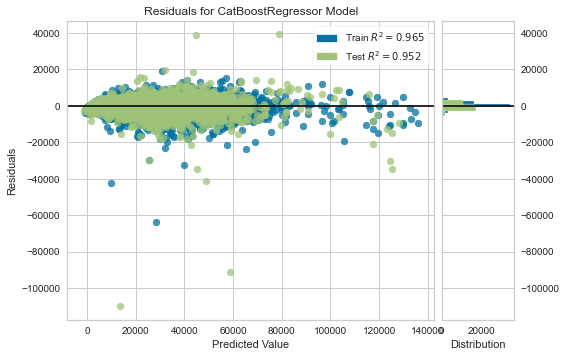

In [46]:
plot_model(catb)

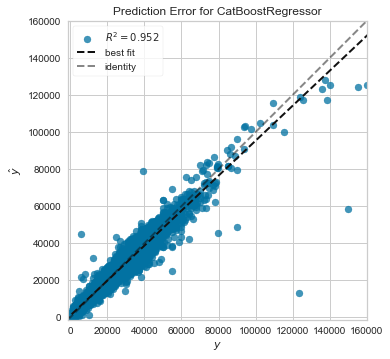

In [47]:
plot_model(catb, plot = 'error')

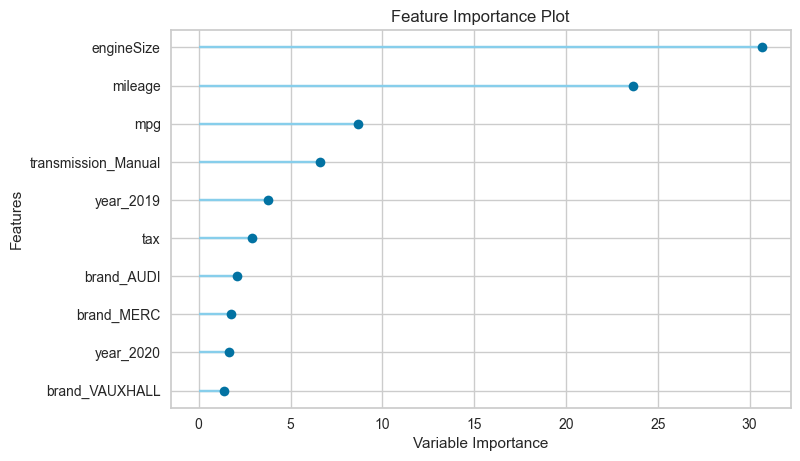

In [48]:
plot_model(catb, plot='feature')

### Predictions:

In [49]:
predict_model(catb);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1323.0860,4646171.6485,2155.4980,0.9519,0.1294,0.0840


The R2 on the test/hold-out set is 0.9519 compared to 0.9587 achieved on 'catb' CV results. 

This is not a significant difference. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 10% that we had separated in the beginning and never exposed to PyCaret).

### Finalize Model for Deployment

In [50]:
final_catb = finalize_model(catb)

### Predict on Unseen Data

The predict_model() function is also used to predict on the unseen dataset. 

The only difference is that this time we will pass the data_unseen parameter. 

data_unseen is the variable created at the beginning of the tutorial and contains 10% (10275 samples) of the original dataset which was never exposed to PyCaret.

In [51]:
unseen_predictions = predict_model(final_catb, data=data_unseen)
unseen_predictions

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,Label
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,AUDI,14591.71
1,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,AUDI,18988.45
2,A3,2014,13900,Automatic,30516,Petrol,30.0,56.5,1.4,AUDI,13432.70
3,A6,2016,19400,Automatic,34030,Diesel,125.0,58.9,2.0,AUDI,18825.69
4,A4,2017,14400,Automatic,32097,Diesel,145.0,72.4,2.0,AUDI,18635.52
...,...,...,...,...,...,...,...,...,...,...,...
10270,CC,2015,10000,Automatic,70920,Diesel,145.0,54.3,2.0,VW,10185.00
10271,California,2019,57991,Automatic,7486,Diesel,260.0,33.2,2.0,VW,56969.96
10272,Caddy Life,2020,22000,Manual,1700,Diesel,150.0,51.4,2.0,VW,23366.15
10273,Caddy,2016,11999,Automatic,59523,Diesel,145.0,55.4,2.0,VW,14020.72


Finally, we can check the R2 on the unseen data predictions our model just made.

In [52]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.price, unseen_predictions.Label, 'R2')

0.9664

As seen, the R2 on the unseen data is 0.9664, which is pretty good and is at par with the R2 value for the test sets.

## Conclusion:

This ends our current project of predicting the car's price based on other features. Here are some other factors to consider, which might be able to improve the model's performance:

 - Perform PCA to reduce the feature space which will prevent overfitting and improve the speed of model training.
 - Use the top 3/4 models and stack them together and use the stacked model for the predictions.
 - Perform data-preprocessing steps such as normalizing the data, removing multicollinearity, removing outliers etc.

